In [1]:
import os, sys, time, json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import optuna
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_param_importances,
)
from optuna.pruners import MedianPruner

# -------------- 0. housekeeping  --------------------------------
k_folds    = 5
max_trials = 1000                    # try up to 1000 trials, but we can interrupt early
os.makedirs("figures", exist_ok=True)

# Redirect stdout to both console + log file
class Tee:
    def __init__(self, *streams):
        self.streams = streams
    def write(self, data):
        for s in self.streams:
            s.write(data)
            s.flush()
    def flush(self):
        for s in self.streams:
            s.flush()

log_file = open("output.txt", "w")
sys.stdout = Tee(sys.__stdout__, log_file)

print(f"Settings  |  k_folds = {k_folds},  max_trials = {max_trials}\n")

# -------------- 1. load data -----------------------------------
sys.path.append(
    r"C:\Users\flori\OneDrive - TU Eindhoven\Master TUe 2024-2025\1BM120 - Decision Making with Artificial Intelligence\Assignment 2"
)
from support import load_dataset

trainset, testset = load_dataset()
num_classes = len(trainset.classes)
print(f"Loaded  |  train = {len(trainset)},  test = {len(testset)}")
print("Classes :", trainset.classes, "\n")

# -------------- 2. define CNN ----------------------------------
class CNN_CV(nn.Module):
    def __init__(self, n_cls, pooltype=0):
        super().__init__()
        self.conv1  = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.relu1  = nn.ReLU()
        if pooltype == 0:
            self.pool1 = nn.MaxPool2d(2, 2)
        else:
            self.pool1 = nn.AvgPool2d(2, 2)

        self.conv2  = nn.Conv2d(16, 16, 3, stride=1, padding=1)
        self.relu2  = nn.ReLU()
        if pooltype == 0:
            self.pool2 = nn.MaxPool2d(2, 2)
        else:
            self.pool2 = nn.AvgPool2d(2, 2)

        # After two 2×2 pools: 60×30 → 30×15 → 15×7, channels=16
        self.fc1     = nn.Linear(16 * 15 * 7, n_cls)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = torch.flatten(x, 1)
        return self.fc1(x)    # raw logits

# -------------- 3. CV + pruning routine ------------------------
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

def cross_validate(lr, wd, pooltype, bs, epochs, trial_id, trial=None):
    """
    Runs k-fold CV, reporting intermediate val‐loss for pruning.
    Returns: mean CV loss, avg_train_curve, avg_val_curve, fold_val_losses.
    """
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_val_losses  = []
    fold_train_epoch = []
    fold_val_epoch   = []

    splits = list(kf.split(trainset))
    for fold, (tr_idx, val_idx) in enumerate(splits, start=1):
        print(f"-- Fold {fold}/{k_folds}  (trial {trial_id})  |  lr={lr:.1e}, wd={wd:.1e}, pool={'max' if pooltype==0 else 'avg'}, bs={bs}, ep={epochs}")

        trainset_CV = Subset(trainset, tr_idx)
        valset_CV   = Subset(trainset, val_idx)
        tr_loader   = DataLoader(trainset_CV, batch_size=bs, shuffle=True,  pin_memory=True, num_workers=4)
        vl_loader   = DataLoader(valset_CV,   batch_size=bs, shuffle=False, pin_memory=True, num_workers=4)

        model_CV = CNN_CV(num_classes, pooltype).to(device)
        optimizer = optim.Adam(model_CV.parameters(), lr=lr, weight_decay=wd)
        criterion = nn.CrossEntropyLoss()

        tr_curve = []
        vl_curve = []

        for ep in range(1, epochs + 1):
            # ---------- TRAIN ----------
            model_CV.train()
            running_loss, correct = 0.0, 0
            for xb, yb in tr_loader:
                xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
                optimizer.zero_grad()
                logits = model_CV(xb)
                loss   = criterion(logits, yb)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                preds = logits.argmax(dim=1)
                correct += (preds == yb).sum().item()

            tr_loss = running_loss / len(tr_loader)
            tr_acc  = 100.0 * correct / len(trainset_CV)
            tr_curve.append(tr_loss)

            # ---------- VALIDATION ----------
            model_CV.eval()
            vloss_sum, vcorrect = 0.0, 0
            with torch.no_grad():
                for xb, yb in vl_loader:
                    xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
                    logits = model_CV(xb)
                    loss   = criterion(logits, yb)
                    vloss_sum += loss.item()
                    preds = logits.argmax(dim=1)
                    vcorrect += (preds == yb).sum().item()

            v_loss = vloss_sum / len(vl_loader)
            v_acc  = 100.0 * vcorrect / len(valset_CV)
            vl_curve.append(v_loss)

            # Print & update TQDM
            print(f"   Epoch {ep:02d}/{epochs}  |  train_loss={tr_loss:.4f} ({tr_acc:.1f}%)  val_loss={v_loss:.4f} ({v_acc:.1f}%)")

            # -------- PRUNE CHECK --------
            if trial is not None:
                step = (fold - 1) * epochs + ep
                trial.report(v_loss, step=step)
                if trial.should_prune():
                    print(f"   >>> Trial {trial.number+1} pruned at fold {fold}, epoch {ep} (val_loss={v_loss:.4f})")
                    raise optuna.TrialPruned()

        fold_train_epoch.append(tr_curve)
        fold_val_epoch.append(vl_curve)
        fold_val_losses.append(vl_curve[-1])
        print(f"   Fold done | final val loss = {vl_curve[-1]:.4f}\n")

    mean_cv = float(np.mean(fold_val_losses))
    print(f"*** Mean CV loss = {mean_cv:.4f} ***\n")

    avg_tr = np.mean(fold_train_epoch, axis=0)
    avg_vl = np.mean(fold_val_epoch, axis=0)
    return mean_cv, avg_tr, avg_vl, fold_val_losses

# -------------- 4. objective + callback -----------------------
history = {k: [] for k in ("lr","wd","pool","bs","ep","cv_loss","train_curve","val_curve","fold_val_losses")}

def objective(trial: optuna.Trial) -> float:
    # 4 hyperparameters to tune
    lr        = trial.suggest_float("lr", 1e-8, 1e-1, log=True)
    wd        = trial.suggest_float("wd", 1e-8, 1e-1, log=True)
    pooltype  = trial.suggest_categorical("pool", [0, 1])
    bs        = trial.suggest_categorical("bs",   [8,16,32,64,128,256])  # batch size
    ep        = trial.suggest_categorical("ep", [5,10,15,20,25,30])   # number of epochs
    t_id      = trial.number + 1

    print(f"== Trial {t_id}/{max_trials}  |  lr={lr:.1e}, wd={wd:.1e}, pool={pooltype}, bs={bs}, ep={ep}")

    try:
        cv_loss, tr_curve, vl_curve, fold_vals = cross_validate(
            lr, wd, pooltype, bs, ep, t_id, trial=trial
        )
    except optuna.TrialPruned:
        print(f"<<< Trial {t_id} pruned >>>\n")
        raise

    # store everything in history
    history["lr"].append(lr)
    history["wd"].append(wd)
    history["pool"].append(pooltype)
    history["bs"].append(bs)
    history["ep"].append(ep)
    history["cv_loss"].append(cv_loss)
    history["train_curve"].append(tr_curve)
    history["val_curve"].append(vl_curve)
    history["fold_val_losses"].append(fold_vals)

    # save learning‐curve figure for this specific trial
    fig, ax = plt.subplots()
    ax.plot(range(1, ep+1), tr_curve, label="train")
    ax.plot(range(1, ep+1), vl_curve, label="val")
    ax.set_xlabel("epoch"); ax.set_ylabel("loss")
    ax.set_title(f"Learning curve | trial {t_id}")
    ax.legend()
    #fig.tight_layout()
    fig.savefig(f"figures/learning_curve_trial_{t_id}.png")
    plt.close(fig)

    return cv_loss

def after_trial_callback(study: optuna.Study, trial: optuna.Trial) -> None:
    t_id       = trial.number + 1
    best_p     = study.best_params
    best_val   = study.best_value
    print(f"   --> After Trial {t_id}: Best so far = {best_p} (CV loss = {best_val:.4f})\n")

    imp = get_param_importances(study)
    print("   Parameter importances:")
    for nm, val in imp.items():
        print(f"      {nm}: {val:.4f}")
    print("")

    fig1 = plot_optimization_history(study)
    #fig1.tight_layout()
    fig1.savefig(f"figures/opt_history_after_trial_{t_id}.png")
    plt.close(fig1)

    # only compute & plot importances after more than one trial
    if len(study.trials) > 1:
        imp = get_param_importances(study)
        print("   Parameter importances:")
        for nm, val in imp.items():
            print(f"      {nm}: {val:.4f}")
        print("")
        fig2 = plot_param_importances(study)
        #fig2.tight_layout()
        fig2.savefig(f"figures/param_importances_after_trial_{t_id}.png")
        plt.close(fig2)
    else:
        print("   Skipping parameter importances (need >1 trial).")

# -------------- 5. create/load study ----------------------------
storage_name = "sqlite:///optuna_study.db"
study_name   = "cnn_pruning_study"

# If the DB file already exists, load that study; otherwise create a new one.
try:
    study = optuna.load_study(study_name=study_name, storage=storage_name)
    print("Loaded existing study; continuing from last trial count:", len(study.trials))
except KeyError:
    study = optuna.create_study(
        study_name=study_name,
        storage=storage_name,
        direction="minimize",
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=0),
    )
    print("Created new study:", study.study_name)

# -------------- 6. run optimization (interruptible) -------------
search_start = time.perf_counter()
try:
    study.optimize(
        objective,
        n_trials=max_trials,
        callbacks=[after_trial_callback],
    )
except KeyboardInterrupt:
    print("==> Interrupted by user. Trials so far have been saved to disk.\n")

elapsed = time.perf_counter() - search_start
print(f"\n### Done (or interrupted) after {elapsed/60:.1f} min. ###")
print("Total trials completed:", len(study.trials))
print("Best hyper‐params so far:", study.best_params)
print(f"Best CV loss = {study.best_value:.4f}")

# store history in the study itself so we can retrieve it later
study.set_user_attr("history", history)

[W 2025-06-03 19:59:35,664] Trial 7 failed with parameters: {'lr': 0.061287781262444135, 'wd': 0.0520152161762041, 'pool': 0, 'bs': 256, 'ep': 5} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\flori\AppData\Roaming\Python\Python312\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\flori\AppData\Local\Temp\ipykernel_18224\3413818634.py", line 190, in objective
    cv_loss, tr_curve, vl_curve, fold_vals = cross_validate(
                                             ^^^^^^^^^^^^^^^
  File "C:\Users\flori\AppData\Local\Temp\ipykernel_18224\3413818634.py", line 120, in cross_validate
    for xb, yb in tr_loader:
                  ^^^^^^^^^
  File "C:\Users\flori\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py", line 733, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "C:\User

C:\Users\flori\AppData\Local\Temp\ipykernel_12696\567735747.py:29: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = plot_optimization_history(study)


AttributeError: 'Axes' object has no attribute 'tight_layout'

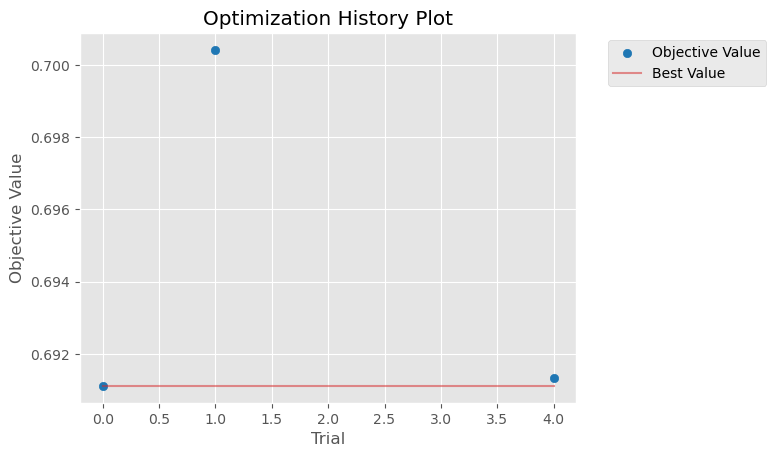

In [ ]:
# Cell [ ]: resume_and_plot.py

import os, json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import optuna
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_param_importances,
)

# -------------- 1. load study from disk ------------------------
storage_name = "sqlite:///optuna_study.db"
study_name   = "cnn_pruning_study"
study = optuna.load_study(study_name=study_name, storage=storage_name)

history = study.user_attrs["history"]

print(f"Loaded study '{study_name}' with {len(study.trials)} trials")
print("Best params so far:", study.best_params)
print(f"Best CV loss = {study.best_value:.4f}")

# -------------- 2. re‐plot overall optimization history -------------
fig = plot_optimization_history(study)
fig.tight_layout()
fig.savefig("figures/opt_history_overall.png")
plt.show()
plt.close(fig)

fig = plot_param_importances(study)
fig.tight_layout()
fig.savefig("figures/param_importances_overall.png")
plt.show()
plt.close(fig)

# -------------- 3. define exactly the same CNN class --------------
import sys
sys.path.append(
    r"C:\Users\flori\OneDrive - TU Eindhoven\Master TUe 2024-2025\1BM120 - Decision Making with Artificial Intelligence\Assignment 2"
)
from support import load_dataset

trainset, testset = load_dataset()
num_classes = len(trainset.classes)

class CNN_CV(nn.Module):
    def __init__(self, n_cls, pooltype=0):
        super().__init__()
        self.conv1  = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.relu1  = nn.ReLU()
        if pooltype == 0:
            self.pool1 = nn.MaxPool2d(2, 2)
        else:
            self.pool1 = nn.AvgPool2d(2, 2)

        self.conv2  = nn.Conv2d(16, 16, 3, stride=1, padding=1)
        self.relu2  = nn.ReLU()
        if pooltype == 0:
            self.pool2 = nn.MaxPool2d(2, 2)
        else:
            self.pool2 = nn.AvgPool2d(2, 2)

        self.fc1 = nn.Linear(16 * 15 * 7, n_cls)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        return self.fc1(x)

# -------------- 4. train the best‐so‐far model on full training set ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best = study.best_params

# unpack best params
lr       = best["lr"]
wd       = best["wd"]
pooltype = best["pool"]
bs       = best["bs"]
ep       = best["ep"]

print("Training final model with best‐found hyperparameters:")
print(f"  lr={lr:.1e}, wd={wd:.1e}, pool={pooltype}, bs={bs}, epochs={ep}\n")

train_loader = DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=4, pin_memory=True)
test_loader  = DataLoader(testset,  batch_size=bs, shuffle=False, num_workers=4, pin_memory=True)

model_final = CNN_CV(num_classes, pooltype).to(device)
optimizer_final = optim.Adam(model_final.parameters(), lr=lr, weight_decay=wd)
criterion_final = nn.CrossEntropyLoss()

# training loop
for epoch in range(1, ep + 1):
    model_final.train()
    running_loss = 0.0
    correct = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        optimizer_final.zero_grad()
        logits = model_final(xb)
        loss = criterion_final(logits, yb)
        loss.backward()
        optimizer_final.step()

        running_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc  = 100.0 * correct / len(trainset)
    print(f"Epoch {epoch:02d}/{ep}  |  Train loss={train_loss:.4f}, Train acc={train_acc:.1f}%")

print("\nFinished training final model.\n")

# -------------- 5. evaluate on test set ------------------------
model_final.eval()
all_preds = []
all_lbls  = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        logits = model_final(xb).cpu()
        all_preds.append(logits.argmax(dim=1))
        all_lbls.append(yb)

all_preds = torch.cat(all_preds).numpy()
all_lbls  = torch.cat(all_lbls).numpy()

cm = confusion_matrix(all_lbls, all_preds, labels=list(range(num_classes)))
fig_cm, ax_cm = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(cm, display_labels=trainset.classes)
disp.plot(ax=ax_cm, cmap="Blues", colorbar=False)
ax_cm.set_title("Confusion matrix (test set) — Final model")
fig_cm.tight_layout()
fig_cm.savefig("figures/confusion_matrix_final.png")
plt.show()
plt.close(fig_cm)

per_class_acc = cm.diagonal() / cm.sum(axis=1)
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(num_classes), per_class_acc)
ax.set_xticks(range(num_classes))
ax.set_xticklabels(trainset.classes, rotation=45, ha="right")
ax.set_ylim(0, 1)
ax.set_ylabel("accuracy")
ax.set_title("Per‐class accuracy (test set) — Final model")
fig.tight_layout()
fig.savefig("figures/per_class_accuracy_final.png")
plt.show()
plt.close(fig)

# -------------- 6. (Optional) plot validation‐curves for each trial ------------
# You can iterate through history if you want more detailed per‐trial analysis,
# but generally the above plots suffice.

import os

# Make sure the directory for per‐trial plots exists
os.makedirs("figures/validation_curves", exist_ok=True)

for i, (tr_curve, vl_curve) in enumerate(zip(history["train_curve"], history["val_curve"]), start=1):
    epochs_i = range(1, len(tr_curve) + 1)
    fig, ax = plt.subplots()
    ax.plot(epochs_i, tr_curve, label="train")
    ax.plot(epochs_i, vl_curve, label="val")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title(f"Trial {i}  —  Validation Curves")
    ax.legend()
    fig.tight_layout()
    fig.savefig(f"figures/validation_curves/trial_{i}_val_curve.png")
    plt.close(fig)

print("All diagnostics + final model plots are saved under ./figures")
print("Notebook cell complete.")